<a href="https://colab.research.google.com/github/jiyoung37/Building_energy_load_classification/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import VotingClassifier
import os
os.makedirs("images", exist_ok=True)

In [2]:
# Load dataset from Github
import pandas as pd

# Use the correct raw GitHub link
url = "https://github.com/jiyoung37/Building_energy_load_classification/raw/refs/heads/main/ENB2012_data.xlsx"

# Read Excel file with the correct engine
df = pd.read_excel(url, engine="openpyxl")

# Display first few rows
df.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [3]:
print(df.info())
print('\n')
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative Compactness       768 non-null    float64
 1   Surface Area               768 non-null    float64
 2   Wall Area                  768 non-null    float64
 3   Roof Area                  768 non-null    float64
 4   Overall Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6    Glazing Area              768 non-null    float64
 7   Glazing Area Distribution  768 non-null    int64  
 8   Heating Load               768 non-null    float64
 9   Cooling Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB
None


       Relative Compactness  Surface Area   Wall Area   Roof Area  \
count            768.000000    768.000000  768.000000  768.000000   
mean               0.764167

# Analyze the correlations between all variables

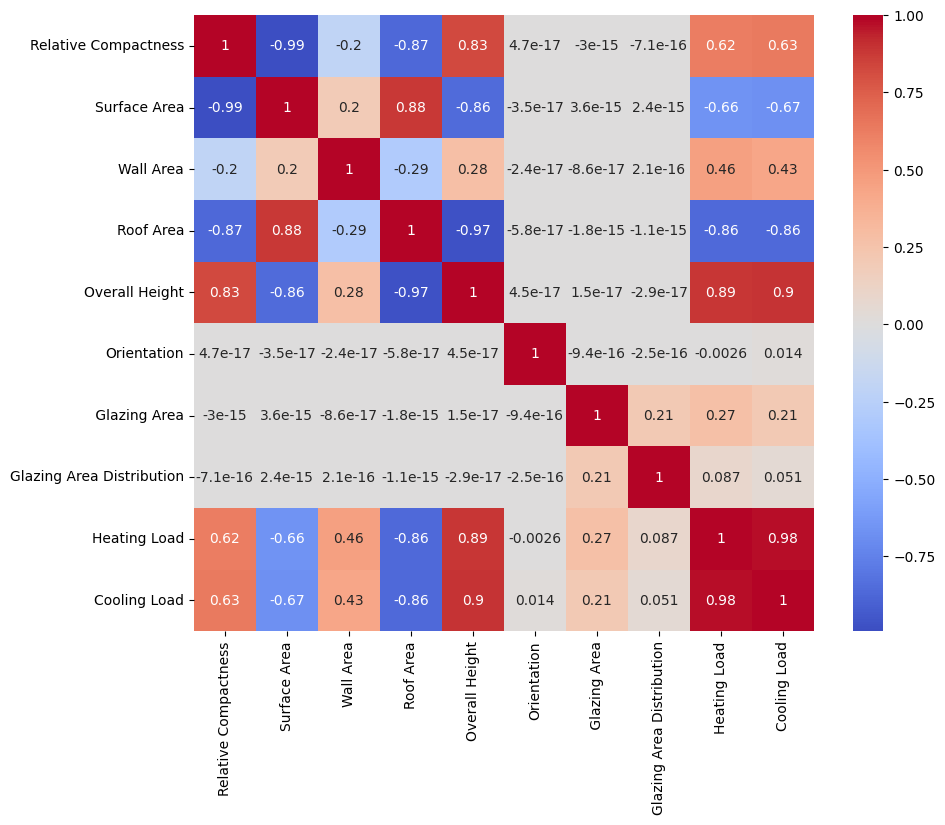

In [4]:
correlations=df.corr()

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0)
plt.savefig("images/heatmap_corr.png", dpi=300, bbox_inches='tight')
plt.show()

### Insights
: the target variables are Heating Load (HL) and Cooling Load (CL)
1. Heating load and Cooling load are very strongly correlated: r=0.98

 -> The improvements in one likely help the other.
2. Both are strongly positively correated with:
- Overall Height: r=0.89(HL) and r=0.90 (CL)
- Relative compactness: r = 0.62 to 0.63

 -> Taller, more compact buildings tend to be more energy-efficient.
3. Both are strongly negatively correlated with:
- Roof Area: r=-0.86
- Surface Area: r=-0.66 to -0.67

 -> Larger surface and roof areas increase heat loss/gain, thus increaseing energ demands.
 4. Glazing area and Glazing area distribution have weak correlation with targets.
 5. Orientation has almost zero correlation with any variable or targets.

# Feature engeneering

## Create new column: total_charges

In a new variable charges_classes, split the buildings into 4 distinct classes with labels 0, 1, 2, 3 according to the 3 quantiles of the new variable created.

In [5]:
df['total_charges']=df['Heating Load'] + df['Cooling Load']

quantiles = df['total_charges'].quantile([0.25,0.5,0.75]).values
df['charges_classes'] = pd.cut(df.total_charges, bins=[-np.inf]+list(quantiles)+[+np.inf], labels=[0,1,2,3])
df.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load,total_charges,charges_classes
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33,36.88,1
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33,36.88,1
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33,36.88,1
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33,36.88,1
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28,49.12,2


# Separate data for training

In [6]:
X=df.drop(columns=['charges_classes', 'total_charges', 'Heating Load','Cooling Load'], errors='ignore')
y=df['charges_classes']

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2)

scaled standardization transformation on the explanatory variables

In [7]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# Modeling

##1. K-nearest neighbors

Hyperparameter to adjust :
- n_neighbors: 2 to 50.

In [8]:
from sklearn.model_selection import GridSearchCV

knn_params={'n_neighbors': range(2,51)}

knn=neighbors.KNeighborsClassifier()
knn_cv=GridSearchCV(knn, knn_params, cv=5)
knn_cv.fit(X_train, y_train)

print('Best KNN parameters:', knn_cv.best_params_)
knn_best=knn_cv.best_estimator_
y_pred_knn=knn_best.predict(X_test)
print('KNN score:', knn_best.score(X_test, y_test))
print('KNN CM: \n')
pd.crosstab(y_test, y_pred_knn, rownames=['Real Class'], colnames=['Predicted Class'])

Best KNN parameters: {'n_neighbors': 3}
KNN score: 0.948051948051948
KNN CM: 



Predicted Class,0,1,2,3
Real Class,,,,
0,35,1,0,0
1,0,36,1,0
2,0,0,34,1
3,0,0,5,41


##2. SVM

Hyperparameter to adjust :
- kernel : 'rbf', 'linear'
- C: 0.1 ; 1 ; 10 ; 50

In [9]:
svm_params={'kernel': ['rbf','linear'], 'C':[0.1,1,10,50]}

svm_model=svm.SVC()
svm_cv=GridSearchCV(svm_model, svm_params, cv=5)
svm_cv.fit(X_train, y_train)

print('Best SVM parameters:', svm_cv.best_params_)
svm_best=svm_cv.best_estimator_
y_pred_svm=svm_best.predict(X_test)
print('SVM score:', svm_best.score(X_test, y_test))
print('SVM CM: \n')
pd.crosstab(y_test, y_pred_svm, rownames=['Real Class'], colnames=['Predicted Class'])

Best SVM parameters: {'C': 50, 'kernel': 'rbf'}
SVM score: 0.948051948051948
SVM CM: 



Predicted Class,0,1,2,3
Real Class,,,,
0,35,1,0,0
1,0,35,2,0
2,0,0,35,0
3,0,0,5,41


##3. RandomForest

Hyperparameter to adjust :
- 'max_features': "sqrt", "log2", None
- 'min_samples_split': Number of paires ranging from 2 to 30.

In [14]:
rf_params={'max_features': ['sqrt','log2', None], 'min_samples_split': range(2,31)}

rf=ensemble.RandomForestClassifier()
rf_cv=GridSearchCV(rf, rf_params, cv=5)
rf_cv.fit(X_train, y_train)

print('Best RF parameters:', rf_cv.best_params_)
rf_best=rf_cv.best_estimator_
y_pred_rf=rf_best.predict(X_test)
print('RF score:', rf_best.score(X_test, y_test))
print('RF CM: \n')
pd.crosstab(y_test, y_pred_svm, rownames=['Real Class'], colnames=['Predicted Class'])

Best RF parameters: {'max_features': 'log2', 'min_samples_split': 8}
RF score: 0.961038961038961
RF CM: 



Predicted Class,0,1,2,3
Real Class,,,,
0,35,1,0,0
1,0,35,2,0
2,0,0,35,0
3,0,0,5,41


##4. Voting classifier

In [13]:
vc=VotingClassifier(estimators=[('knn', knn_best), ('svm', svm_best), ('rf', rf_best)], voting='hard')
vc.fit(X_train, y_train)

y_pred_vc=vc.predict(X_test)

print('VC score', vc.score(X_test, y_test))
print('VC CM: \n')
pd.crosstab(y_test, y_pred_vc, rownames=['Real Class'], colnames=['Predicted Class'])

VC score 0.9545454545454546
VC CM: 



Predicted Class,0,1,2,3
Real Class,,,,
0,35,1,0,0
1,0,36,1,0
2,0,0,35,0
3,0,0,5,41


# Model explainability with SHAP

Note: SHAP works best with tree-based models like RandomForest, XGBoost, etc. For SVM or KNN, SHAP can still be used but is less intuitive and may require KernelExplainer (slower).

 99%|===================| 2441/2456 [00:19<00:00]       

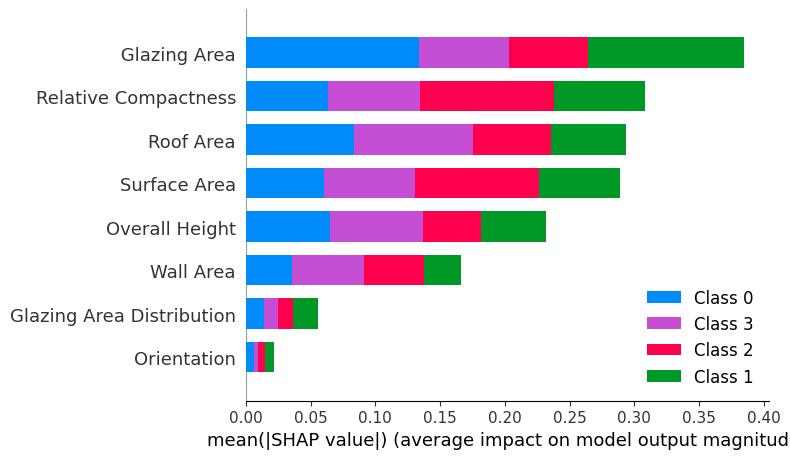

<Figure size 640x480 with 0 Axes>

In [15]:
import shap


X_train_df = pd.DataFrame(X_train, columns=df.drop(columns=['total_charges', 'charges_classes', 'Heating Load','Cooling Load']).columns)

explainer = shap.Explainer(rf_best, X_train_df)
shap_values = explainer(X_train_df)

plt.figure()
shap.summary_plot(shap_values, X_train_df, plot_type="bar")
plt.savefig("images/shap_summary_bar.png", dpi=300, bbox_inches='tight')

### Insights
- All top features (like Glazing Area and Relative Compactness) influence all four classes fairly consistently.

- Lower-ranked features (Orientation, Glazing Distribution) have very small or near-zero average SHAP values across all classes.
